## Investigating Concentrated Liquidity and Impermanent Loss

### Goals
- Look at various ranges of price for each token across time and fee collection
- Want to understand how much fees need to be collected to cover the impermanent loss
- Try to figure out the best ranges based on estimates of total price changes

### Questions
- Should the program be able to apply re-balance using geometric mean?
- Should linear regression be used to help find the answers?  Or just look at 3D plots?
- Can look at both compounding and just collecting fees


### Notes
- Don't bother trying to calculate the fees generated based on volume, just figure out what the fees need to be based on the "final" price of the tokens
- Create "high-side" and "low-side" outs and figure out the fees required and and what the APR would need to average given a timeframe that it did stay in the range 
- Then can get fancy and do re-balances, etc.

### Ideas
- Set a future date and then a list of prices and a probability for hitting each one at the end of the period.  Then calculate the difference in impermanent loss assuming you are re-balancing and compounding



In [ ]:
# Look at impermanent loss with a 10% increase 
import helper_classes as hc

seed_usd = 10000
btc = hc.Token("BTC", 97500)
usdc = hc.Token("USDC", 1)

lp = hc.LiquidityPool(btc, usdc)
lp.initialize_range(seed_usd, 10, 10)
btc.price *= 1.1
lp.update_token_balances(30)
print(lp)


In [ ]:
# Look at IL with a ± 20% range chasing the price
import helper_classes as hc

seed_usd = 10000
btc = hc.Token("BTC", 97500)
usdc = hc.Token("USDC", 1)

lp = hc.LiquidityPool(btc, usdc)
lp.initialize_range(seed_usd, 10, 10)
price = [1, 1, -1, -1, -1, 1]
for i in price:
    btc.price *= (1 + i/10)
    lp.update_token_balances(30)
    lp.rebalance(10, 10)
print(lp)

In [ ]:
# Loop LP price and duration and check APR required
import numpy as np
import pandas as pd
import helper_classes as hc
import matplotlib.pyplot as plt

seed_usd = 10000
btc = hc.Token("BTC", 97500)
usdc = hc.Token("USDC", 1)
lp = hc.LiquidityPool(btc, usdc)
lp.initialize_range(seed_usd, 10, 10)
aprs = []

for price in np.arange(90000, 110000, 1000):
    for duration in np.arange(0, 70, 7):
        btc.price = price
        lp.update_token_balances(duration)
        data = [price, duration, lp.apr]
        aprs.append(data)

data = pd.DataFrame(aprs, columns=['price', 'duration', 'apr'])
print(data)

In [ ]:
# Testers
import helper_classes as hc

seed_usd = 10000
btc = hc.Token("BTC", 97500)
usdc = hc.Token("USDC", 1)
eth = hc.Token("ETH", 3600)

lp = hc.LiquidityPool(btc, usdc)
lp.initialize_range(seed_usd, 10, 15)
print(lp)
lp.token_x.price = 110000
lp.update_token_balances(30)
print(lp)

lp2 = hc.LiquidityPool(eth, btc)
lp2.initialize_range(seed_usd, 10, 10)
print(lp2)
lp2.token_x.price = 3800
lp2.token_y.price = 110000
lp2.update_token_balances(30)
print(lp2)

In [ ]:
# Test 2
import helper_classes as hc

seed_usd = 10000
btc = hc.Token("BTC", 97500)
usdc = hc.Token("USDC", 1)

lp = hc.LiquidityPool(btc, usdc)
lp.initialize_range(seed_usd, 10, 10)
print(lp)
btc.price *= 1.05
lp.update_token_balances(10)
print(lp)
lp.coumpound_fees(350)
print(lp)

In [32]:
# Get historical pricing data
import helper_classes as hc
import pandas as pd

api_id = 'bitcoin'
start = pd.Timestamp('2024-12-12')
end = pd.Timestamp('2025-01-11')
month_data = pd.DataFrame(hc.get_historical_prices(api_id, start, end)).T

start = pd.Timestamp('2024-10-12')
ninety_data = pd.DataFrame(hc.get_historical_prices(api_id, start, end)).T

start = pd.Timestamp('2024-01-12')
year_data = pd.DataFrame(hc.get_historical_prices(api_id, start, end)).T

Getting historical in_data for bitcoin
Try #1
Getting historical in_data for bitcoin
Try #1
Getting historical in_data for bitcoin
Try #1


<Axes: >

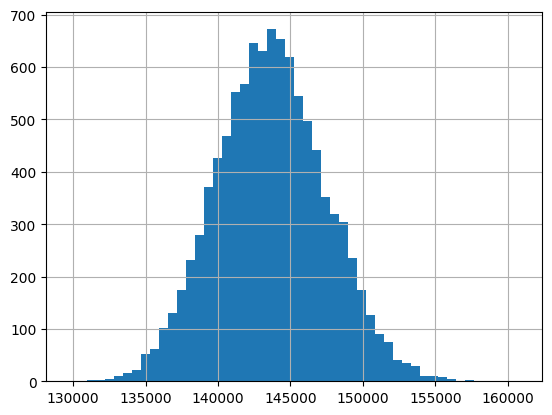

In [33]:
# Use Weiner process to get future price predictions
data = ninety_data.copy()
data['gain'] = data['price'].pct_change()
mean_gain = data['gain'].mean()
std_gain = data['gain'].std()

btc = hc.Token("BTC", 95000)
days = 90
iterations = 10000
b = hc.Brownian()
predict = []
for i in range(iterations):
    x = b.stock_price(btc.price, mean_gain, std_gain, days, 1)
    predict.append(x)
df = pd.DataFrame(predict).T
end = df.iloc[-1]
end.hist(bins=50)

In [34]:
# Calculate IL for each price case and look at the 95th percentile value
btc = hc.Token("BTC", 95000)
usdc = hc.Token("USDC", 1)
lp = hc.LiquidityPool(btc, usdc)
seed_usd = 10000
lp.initialize_range(seed_usd, 10, 10)
il = []
for idx, val in end.items():
    btc.price = val
    lp.update_token_balances(days)
    il.append(lp.impermanent_loss)
result = pd.Series(il)
pct_95 = result.quantile(0.95)
print(
    f"95th percentile = {pct_95:.2f} | APR Required = {pct_95/seed_usd*100*365/days:.1f}%\n"
    f"Mean = {result.mean():.2f} | APR Required = {result.mean()/seed_usd*100*365/days:.1f}%"
    )

95th percentile = 5502.34 | APR Required = 223.2%
Mean = 4840.28 | APR Required = 196.3%
